In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

tfds.__version__


'4.9.8'

In [25]:
batch_size = 32
img_height = 180
img_width = 180

data_dir = "C:/Users/DM/Documents/yh/AIFFEL/Exploration/data/flower_photos"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# 절반 나누기: val/test 10%씩
val_batches = tf.data.experimental.cardinality(val_test_ds).numpy() // 2
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)


Found 7340 files belonging to 6 classes.
Using 5872 files for training.
Found 7340 files belonging to 6 classes.
Using 1468 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'flower_photos', 'roses', 'sunflowers', 'tulips']


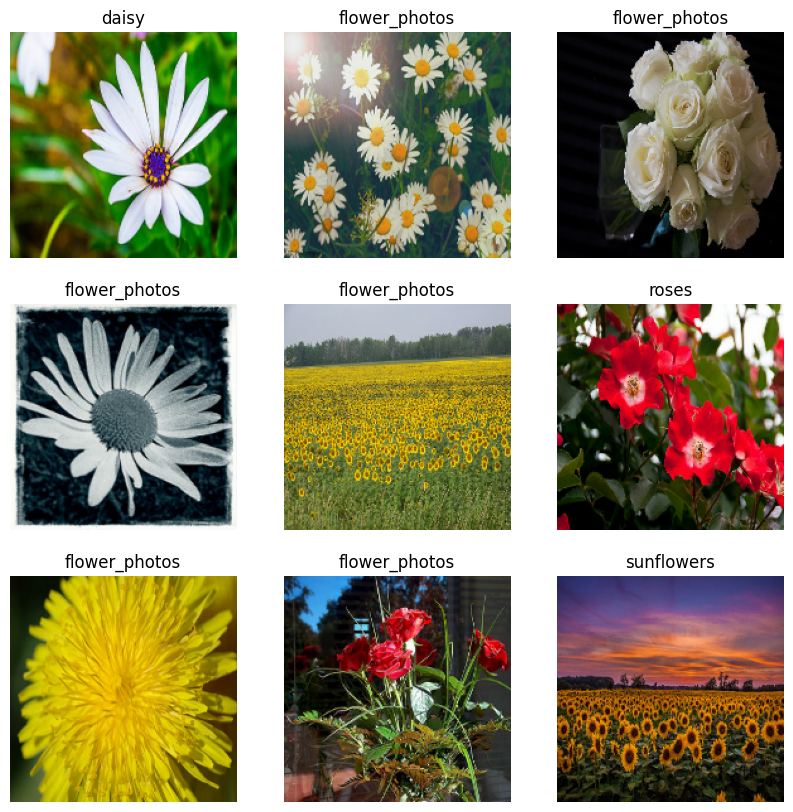

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 1) VGG-16

In [30]:
from tensorflow.keras import layers, models

input_layer = layers.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(input_layer)

# Conv Block 1
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Conv Block 2
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Conv Block 3
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Conv Block 4 (선택)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

# FC Layer
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output Layer (6-class)
output_layer = layers.Dense(6, activation='softmax')(x)

# 모델 정의
model = models.Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 615,846 (2.35 MB)

 Trainable params: 615,846 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 146s 784ms/step - accuracy: 0.4606 - loss: 1.9949 - val_accuracy: 0.5136 - val_loss: 1.4246
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 149s 808ms/step - accuracy: 0.4994 - loss: 1.4264 - val_accuracy: 0.5149 - val_loss: 1.2918
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 146s 795ms/step - accuracy: 0.5001 - loss: 1.3234 - val_accuracy: 0.5258 - val_loss: 1.2650
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 148s 804ms/step - accuracy: 0.4942 - loss: 1.2892 - val_accuracy: 0.5136 - val_loss: 1.2019
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 148s 803ms/step - accuracy: 0.4943 - loss: 1.2276 - val_accuracy: 0.5109 - val_loss: 1.1764
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 147s 800ms/step - accuracy: 0.4985 - loss: 1.2180 - val_accuracy: 0.5245 - val_loss: 1.1186
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 146s 793ms/step - accuracy: 0.4966 - loss: 1.1745 - val_accuracy: 0.5245 - val_loss: 1.0982
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 144s 782ms/step - accuracy: 0.4960 -

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"테스트 정확도: {test_acc:.4f}")
print(f"테스트 손실값: {test_loss:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.4877 - loss: 1.1096
✅ 테스트 정확도: 0.4959
✅ 테스트 손실값: 1.1235


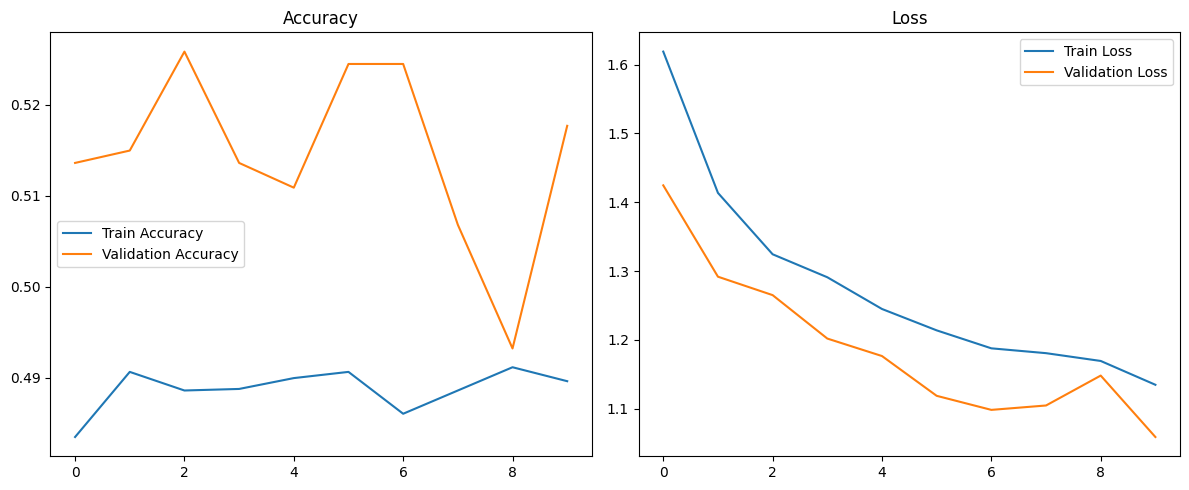

In [34]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### 2) pre_trained

In [35]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import tensorflow as tf

# Pre-trained VGG16 모델 로드
base_model = VGG16(input_shape=(180, 180, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Functional API 모델 정의
inputs = layers.Input(shape=(180, 180, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)

vgg_model = models.Model(inputs=inputs, outputs=outputs)
vgg_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,783,174 (56.39 MB)

 Trainable params: 67,462 (263.52 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [38]:
from tensorflow.keras.optimizers import Adam
# Modify the Adam optimizer with a lower learning rate and adjusted betas
custom_adam = Adam(learning_rate=1e-4)

vgg_model.compile(optimizer =custom_adam,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

vgg_hist = vgg_model.fit(
    train_ds,                  # Dataset 객체 그대로 사용
    epochs=10,
    validation_data=val_ds
)


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.2560 - loss: 2.2789 - val_accuracy: 0.4130 - val_loss: 1.4496
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.3720 - loss: 1.7413 - val_accuracy: 0.4633 - val_loss: 1.3210
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.4290 - loss: 1.5869 - val_accuracy: 0.4579 - val_loss: 1.2596
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.4390 - loss: 1.4583 - val_accuracy: 0.4688 - val_loss: 1.1928
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.4467 - loss: 1.3607 - val_accuracy: 0.4470 - val_loss: 1.2268
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.4633 - loss: 1.3069 - val_accuracy: 0.4416 - val_loss: 1.1875
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.4677 - loss: 1.2784 - val_accuracy: 0.4416 - val_loss: 1.1651
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.4756 - loss: 1.2472 - val_accu